In [31]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
#Load the data

train_housing=pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test_housing=pd.read_csv("house-prices-advanced-regression-techniques/test.csv")


In [3]:
train_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [30]:
#Looking at predictive features
corr_matrix = train_housing.corr()

corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice           1.000000
area_per_quality    0.832057
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
YearRemodAdd        0.507101
MasVnrArea          0.472614
Fireplaces          0.466929
BsmtFinSF1          0.386420
LotFrontage         0.349876
WoodDeckSF          0.324413
2ndFlrSF            0.319334
OpenPorchSF         0.315856
HalfBath            0.284108
LotArea             0.263843
GarageYrBlt         0.261366
BsmtFullBath        0.227122
BsmtUnfSF           0.214479
BedroomAbvGr        0.168213
ScreenPorch         0.111447
PoolArea            0.092404
3SsnPorch           0.044584
BsmtFinSF2         -0.011378
BsmtHalfBath       -0.016844
MiscVal            -0.021190
Id                 -0.021917
LowQualFinSF       -0.025606
OverallCond        -0.077856
EnclosedPorch 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a563f2278>,
      dtype=object)

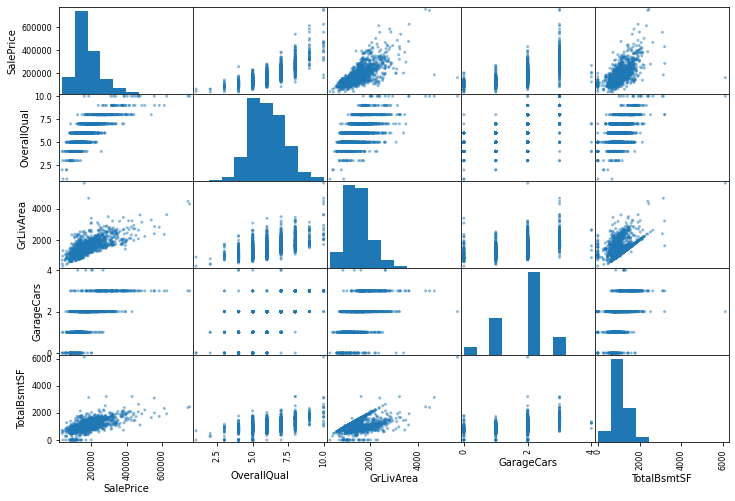

In [6]:
#plotting features with respect to Sale Price
attributes = ["SalePrice", "OverallQual", "GrLivArea",
"GarageCars","TotalBsmtSF"]

scatter_matrix(train_housing[attributes], figsize=(12, 8))

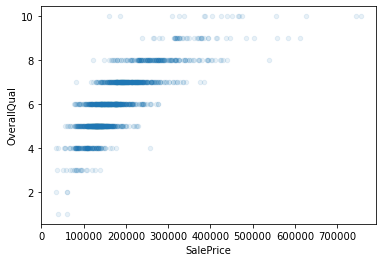

In [7]:
train_housing.plot(kind="scatter", x="SalePrice", y="OverallQual",
alpha=0.1)

In [8]:
#creating a new feature
train_housing["area_per_quality"] = train_housing["GrLivArea"]*train_housing["OverallQual"]

In [9]:
corr_matrix = train_housing.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice           1.000000
area_per_quality    0.832057
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
YearRemodAdd        0.507101
GarageYrBlt         0.486362
MasVnrArea          0.477493
Fireplaces          0.466929
BsmtFinSF1          0.386420
LotFrontage         0.351799
WoodDeckSF          0.324413
2ndFlrSF            0.319334
OpenPorchSF         0.315856
HalfBath            0.284108
LotArea             0.263843
BsmtFullBath        0.227122
BsmtUnfSF           0.214479
BedroomAbvGr        0.168213
ScreenPorch         0.111447
PoolArea            0.092404
MoSold              0.046432
3SsnPorch           0.044584
BsmtFinSF2         -0.011378
BsmtHalfBath       -0.016844
MiscVal            -0.021190
Id                 -0.021917
LowQualFinSF       -0.025606
YrSold        

In [10]:
all_features = train_housing

all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

# taken from lavanyashukla01 on kaggle

#Data Cleaning
def handle_missing(train_stats,features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(train_stats['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(train_stats['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(train_stats['SaleType'].mode()[0])
    features['MSZoning'] = train_stats.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = train_stats.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features


        

In [11]:
#Checking that we filled all missing values
handle_missing(all_features,all_features)
all_features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1460 non-null   int64  
 1   MSSubClass        1460 non-null   object 
 2   MSZoning          1460 non-null   object 
 3   LotFrontage       1460 non-null   float64
 4   LotArea           1460 non-null   int64  
 5   Street            1460 non-null   object 
 6   Alley             1460 non-null   object 
 7   LotShape          1460 non-null   object 
 8   LandContour       1460 non-null   object 
 9   Utilities         1460 non-null   object 
 10  LotConfig         1460 non-null   object 
 11  LandSlope         1460 non-null   object 
 12  Neighborhood      1460 non-null   object 
 13  Condition1        1460 non-null   object 
 14  Condition2        1460 non-null   object 
 15  BldgType          1460 non-null   object 
 16  HouseStyle        1460 non-null   object 


In [12]:
housing = all_features.drop("SalePrice", axis=1)
housing_labels = all_features["SalePrice"].copy()

#counting all categorical features
num_cols = housing.columns[housing.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
num_cols=num_cols.drop(['Id'])
#one hot encoding
hot_all_features = pd.get_dummies(housing)

In [13]:
hot_all_features.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [14]:
#scaling numerical features

scaler = StandardScaler()

hot_all_features[num_cols] = scaler.fit_transform(hot_all_features[num_cols])


hot_all_features.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,-0.231877,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0,0,0,1,0,0,0,0,1,0
1,2,0.437043,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,0,0,0,1,0,0,0,0,1,0
2,3,-0.098093,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0,0,0,1,0,0,0,0,1,0
3,4,-0.454850,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0,0,0,1,1,0,0,0,0,0
4,5,0.615421,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,0,0,0,1,0,0,0,0,1,0


In [15]:
# preprocessing test set

test_housing["area_per_quality"] = test_housing["GrLivArea"]*test_housing["OverallQual"]
test_all_features = test_housing

test_all_features['MSSubClass'] = test_all_features['MSSubClass'].apply(str)
test_all_features['YrSold'] = test_all_features['YrSold'].astype(str)
test_all_features['MoSold'] = test_all_features['MoSold'].astype(str)
handle_missing(all_features,test_all_features)


#one hot encoding
test_hot_all_features = pd.get_dummies(test_housing)

test_hot_all_features[num_cols] = scaler.transform(test_hot_all_features[num_cols])


In [16]:
test_hot_all_features.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,-0.231877,0.110763,-0.795151,0.381743,-0.340077,-1.156380,-0.570750,0.053428,0.604293,...,0,0,0,1,0,0,0,0,1,0
1,1462,0.437043,0.375850,-0.071836,0.381743,-0.439440,-1.301740,0.027027,1.051363,-0.288653,...,0,0,0,1,0,0,0,0,1,0
2,1463,-0.098093,0.332053,-0.795151,-0.517200,0.852269,0.636400,-0.570750,0.761852,-0.288653,...,0,0,0,1,0,0,0,0,1,0
3,1464,-0.454850,-0.054002,-0.071836,0.381743,0.885390,0.636400,-0.460051,0.347326,-0.288653,...,0,0,0,1,0,0,0,0,1,0
4,1465,0.615421,-0.552407,1.374795,-0.517200,0.686666,0.345679,-0.570750,-0.396190,-0.288653,...,0,0,0,1,0,0,0,0,1,0


In [18]:
hot_all_features['SalePrice']=housing_labels
hot_all_features.head()


housing = hot_all_features.drop("SalePrice", axis=1)
housing_labels = hot_all_features["SalePrice"].copy()



In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [26]:
#training decision tree regressor
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, housing, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [33955.79345024 39335.89943773 39921.83898304 48159.0523799
 42492.62058779 29890.13096279 33799.45607449 27533.1874923
 58789.23364869 35936.11691256]
Mean: 38981.332992953896
Standard deviation: 8746.50843374001


In [27]:
#training linear regression
lin_reg = LinearRegression()
lin_scores = cross_val_score(tree_reg, housing, housing_labels, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [34678.23901594 41738.92856163 36791.35382981 41288.73264609
 44459.77885246 30775.49937322 44734.76079007 26215.0281829
 50448.98085663 35312.59704819]
Mean: 38644.389915693915
Standard deviation: 6881.147156720649


In [29]:
# training random forest
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, housing, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [24502.59057129 27463.70296689 25816.76667233 38369.48373449
 33806.56192805 27449.94005547 23542.00272612 23408.36483744
 43930.7415984  23611.44257394]
Mean: 29190.159766443492
Standard deviation: 6772.524860712749
